# 核支持向量机实验

0-1损失模型(p=0)、铰链损失模型(p=1)，二次铰链损失模型(p=2)的核支持向量机的增广拉格朗日函数分别为
$$
L_{\sigma}(c,b,u;\lambda)=\frac{1}{2}c^{\top}Kc+C\|u_+\|_p+\frac{\sigma}{2}\|u-\big({\mathbf 1}-{\rm diag}(y)K c-b*y-\frac{\boldsymbol{\lambda}}{\sigma}\big)\|^2-\frac{\|\boldsymbol{\lambda}\|^2}{2\sigma},
$$
其中模型参数$C>0$,$\sigma>0$, $K$是核函数在数据集上的核矩阵.

上述三个模型分别简写$\ell_0$-KSVM (L0-KSVM), $\ell_1$-KSVM (L1-KSVM), $\ell_2$-KSVM (L2-KSVM). 

文献

[1] 叶颀, 谭露琳, 刘春光, 林荣荣，陈艳楠, 胡耀华.《最优化方法与机器学习》, 科学出版社“十四五”普通高等教育规划教材, 2025

[2] Rongrong Lin, Yingjia Yao, Yulan Liu, Kernel Support Vector Machine Classifiers with 𝓁0-Norm Hinge Loss, Neurocomputing,2024, 589:127669.

[3] Mohammed J. Zaki, Wagner Meira  Jr., Data Mining and Machine Learning Fundamental Concepts and Algorithms (2nd, 2020),p.540

三种模型的求解算法:

$\ell_1$-KSVM: 随机梯度上升（Stochastic Gradient Ascent）[3]

$\ell_2$-KSVM: sklearn内置函数或二次规划求解器qpsolvers求解（直接调用）

$\ell_0$-KSVM: 交替方向乘子法(ADMM) （参考[2]）

注1：ADMM除了可以求解$\ell_0$-KSVM也可以类似推导来求解$\ell_1$-KSVM(见[1], p.188页)和$\ell_2$-KSVM

注2：实验核函数默认高斯核(rbf)，数据集Double Circles

# 0. 目录


1. 编程需要准备的通用的包、数据集和预处理

2.  $\ell_1$-KSVM: Stochastic Gradient Ascent
    
3.  $\ell_2$-KSVM by sklearn

4.  $\ell_2$-KSVM by qbsolvers

5.  $\ell_0$-KSVM by ADMM

6. 练习

# 1. 编程需要准备的通用的包、数据集和预处理

1.1 Python编程实现本实验所需要用到的通用的包

In [2]:
#Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels  
import time

1.2 模拟数据集Double Circles生成和预处理

Dataset: Double Circles

https://scikit-learn.org/0.19/modules/generated/sklearn.datasets.make_circles.html

X train shape (900, 2)
X test shape (600, 2)


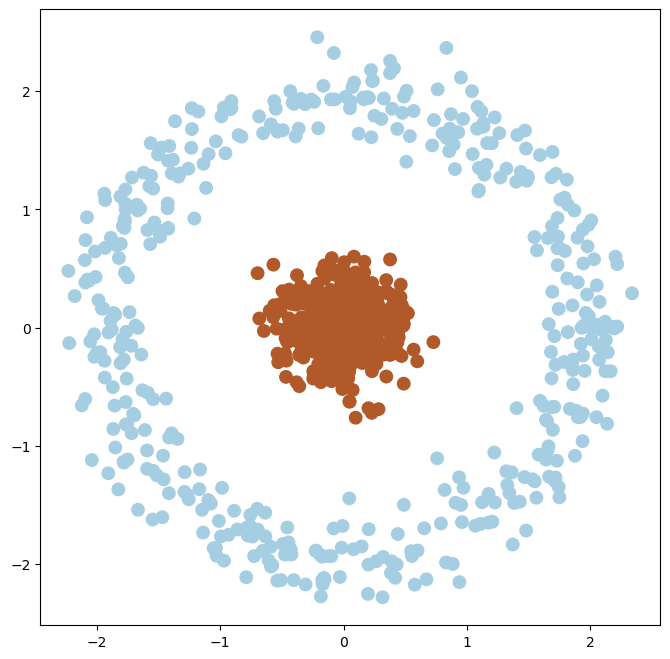

In [9]:
from sklearn.datasets import  make_circles
random.seed(6)
X,Y=make_circles(n_samples=1500,noise=0.1,factor=0.1,random_state=3)

from sklearn import preprocessing 
Y[np.where(Y==0)]=-1  #Transform label 0，1 to label -1，1
Standardscaler = preprocessing.StandardScaler() 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
X = Standardscaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=33)
print('X train shape',X_train.shape)
print('X test shape',X_test.shape)

plt.rcParams['figure.figsize'] = (8, 8) 
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=80, cmap=plt.cm.Paired)

# 2. $\ell_1$-KSVM: Stochastic Gradient Ascent

2.1 Stochastic Gradient Ascent

In [28]:
#L2 KSVM: Stochastic Gradient Ascent
C1=8  #参数可调
start1 = time.time()
K1 = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
Ktilde=K1+1  #augmented kernel matrix
m=np.shape(X_train)[0]
a=np.random.random(m)
for k in range(100):
    ak=a.copy()
    for i in range(m):
        ak[i]=ak[i]+(1-y_train[i]*np.dot(np.multiply(ak,y_train),Ktilde[i,:]))/(K1[i,i]+1)
        if ak[i]<0:
            ak[i]=0
        elif ak[i]>C1:
            ak[i]=C1
        else:
            ak[i]=ak[i]
#     print(np.linalg.norm(ak-a,2))
    if np.linalg.norm(ak-a,2)<0.12:
        print('The stop rule is satisfied with the iteration k=',k)
        break
    else:
        a=ak.copy()

end1 = time.time()
Iter1 = k+1

print('Train Accuracy=', accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
K_test1 = pairwise_kernels(X_test,X_train, metric='rbf') +1
print('Test Accuracy=', accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))

The stop rule is satisfied with the iteration k= 46
Train Accuracy= 1.0
Test Accuracy= 1.0


2.2 Illustration of numerical results

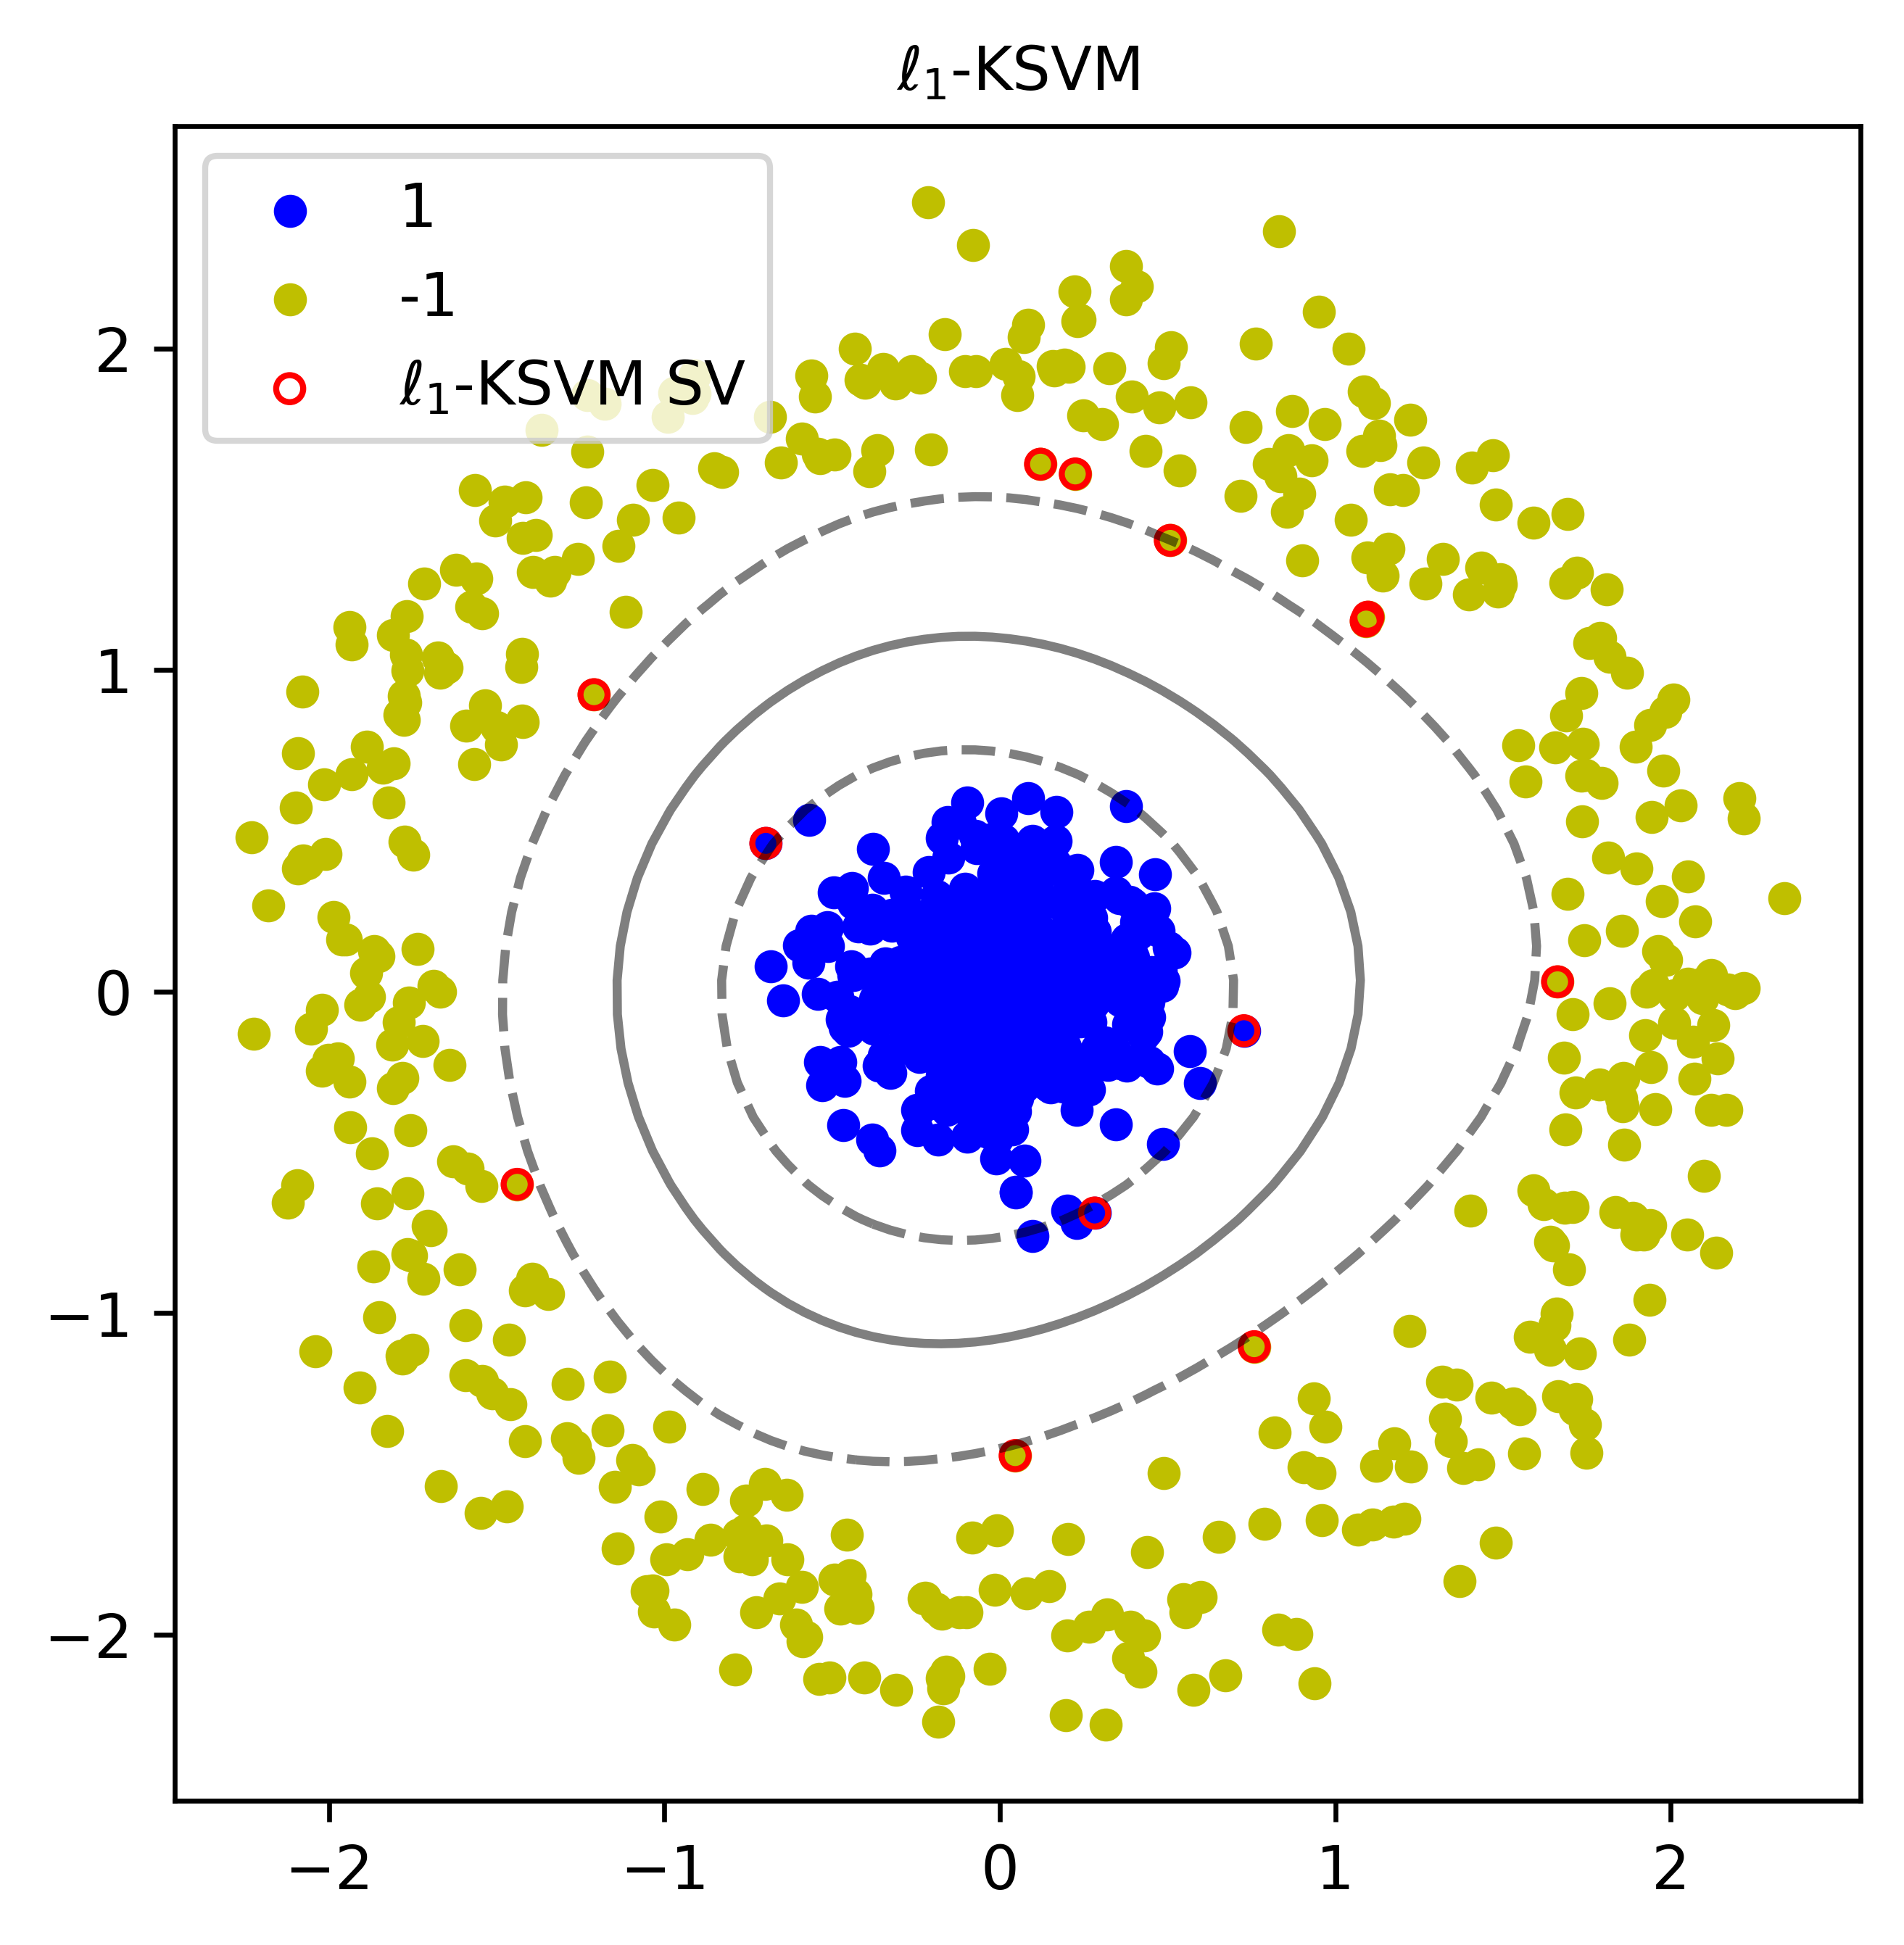

In [29]:
# ##L1KSVM:plot the decision function 
plt.rcParams['figure.figsize'] = (5, 5) 
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier1 = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') +1
Y_classifiervalue1=np.dot(K_classifier1,np.multiply(a,y_train) )   
Z=Y_classifiervalue1.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv1=np.nonzero(a)[0] 
sv_L1Loss = X_train[index_sv1]  #support vectors
plt.scatter(sv_L1Loss[:, 0],sv_L1Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_1$-KSVM SV')
plt.legend(loc = 'upper left')
plt.title(r'$\ell_1$-KSVM',fontsize=10)
plt.savefig('KSVM_DoubleCircle_L1KSVM.png', bbox_inches='tight')

# 3. $\ell_2$-KSVM by sklearn

3.1 sklearn

In [30]:
from sklearn.svm import SVC  #build-in function
C2 = 4 #参数可调
start2 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C=C2,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end2 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#print('Total number of SV on canonical hyperplane:',support_vector_indices_canonical.shape[0])

3.2 Illustration of numerical results

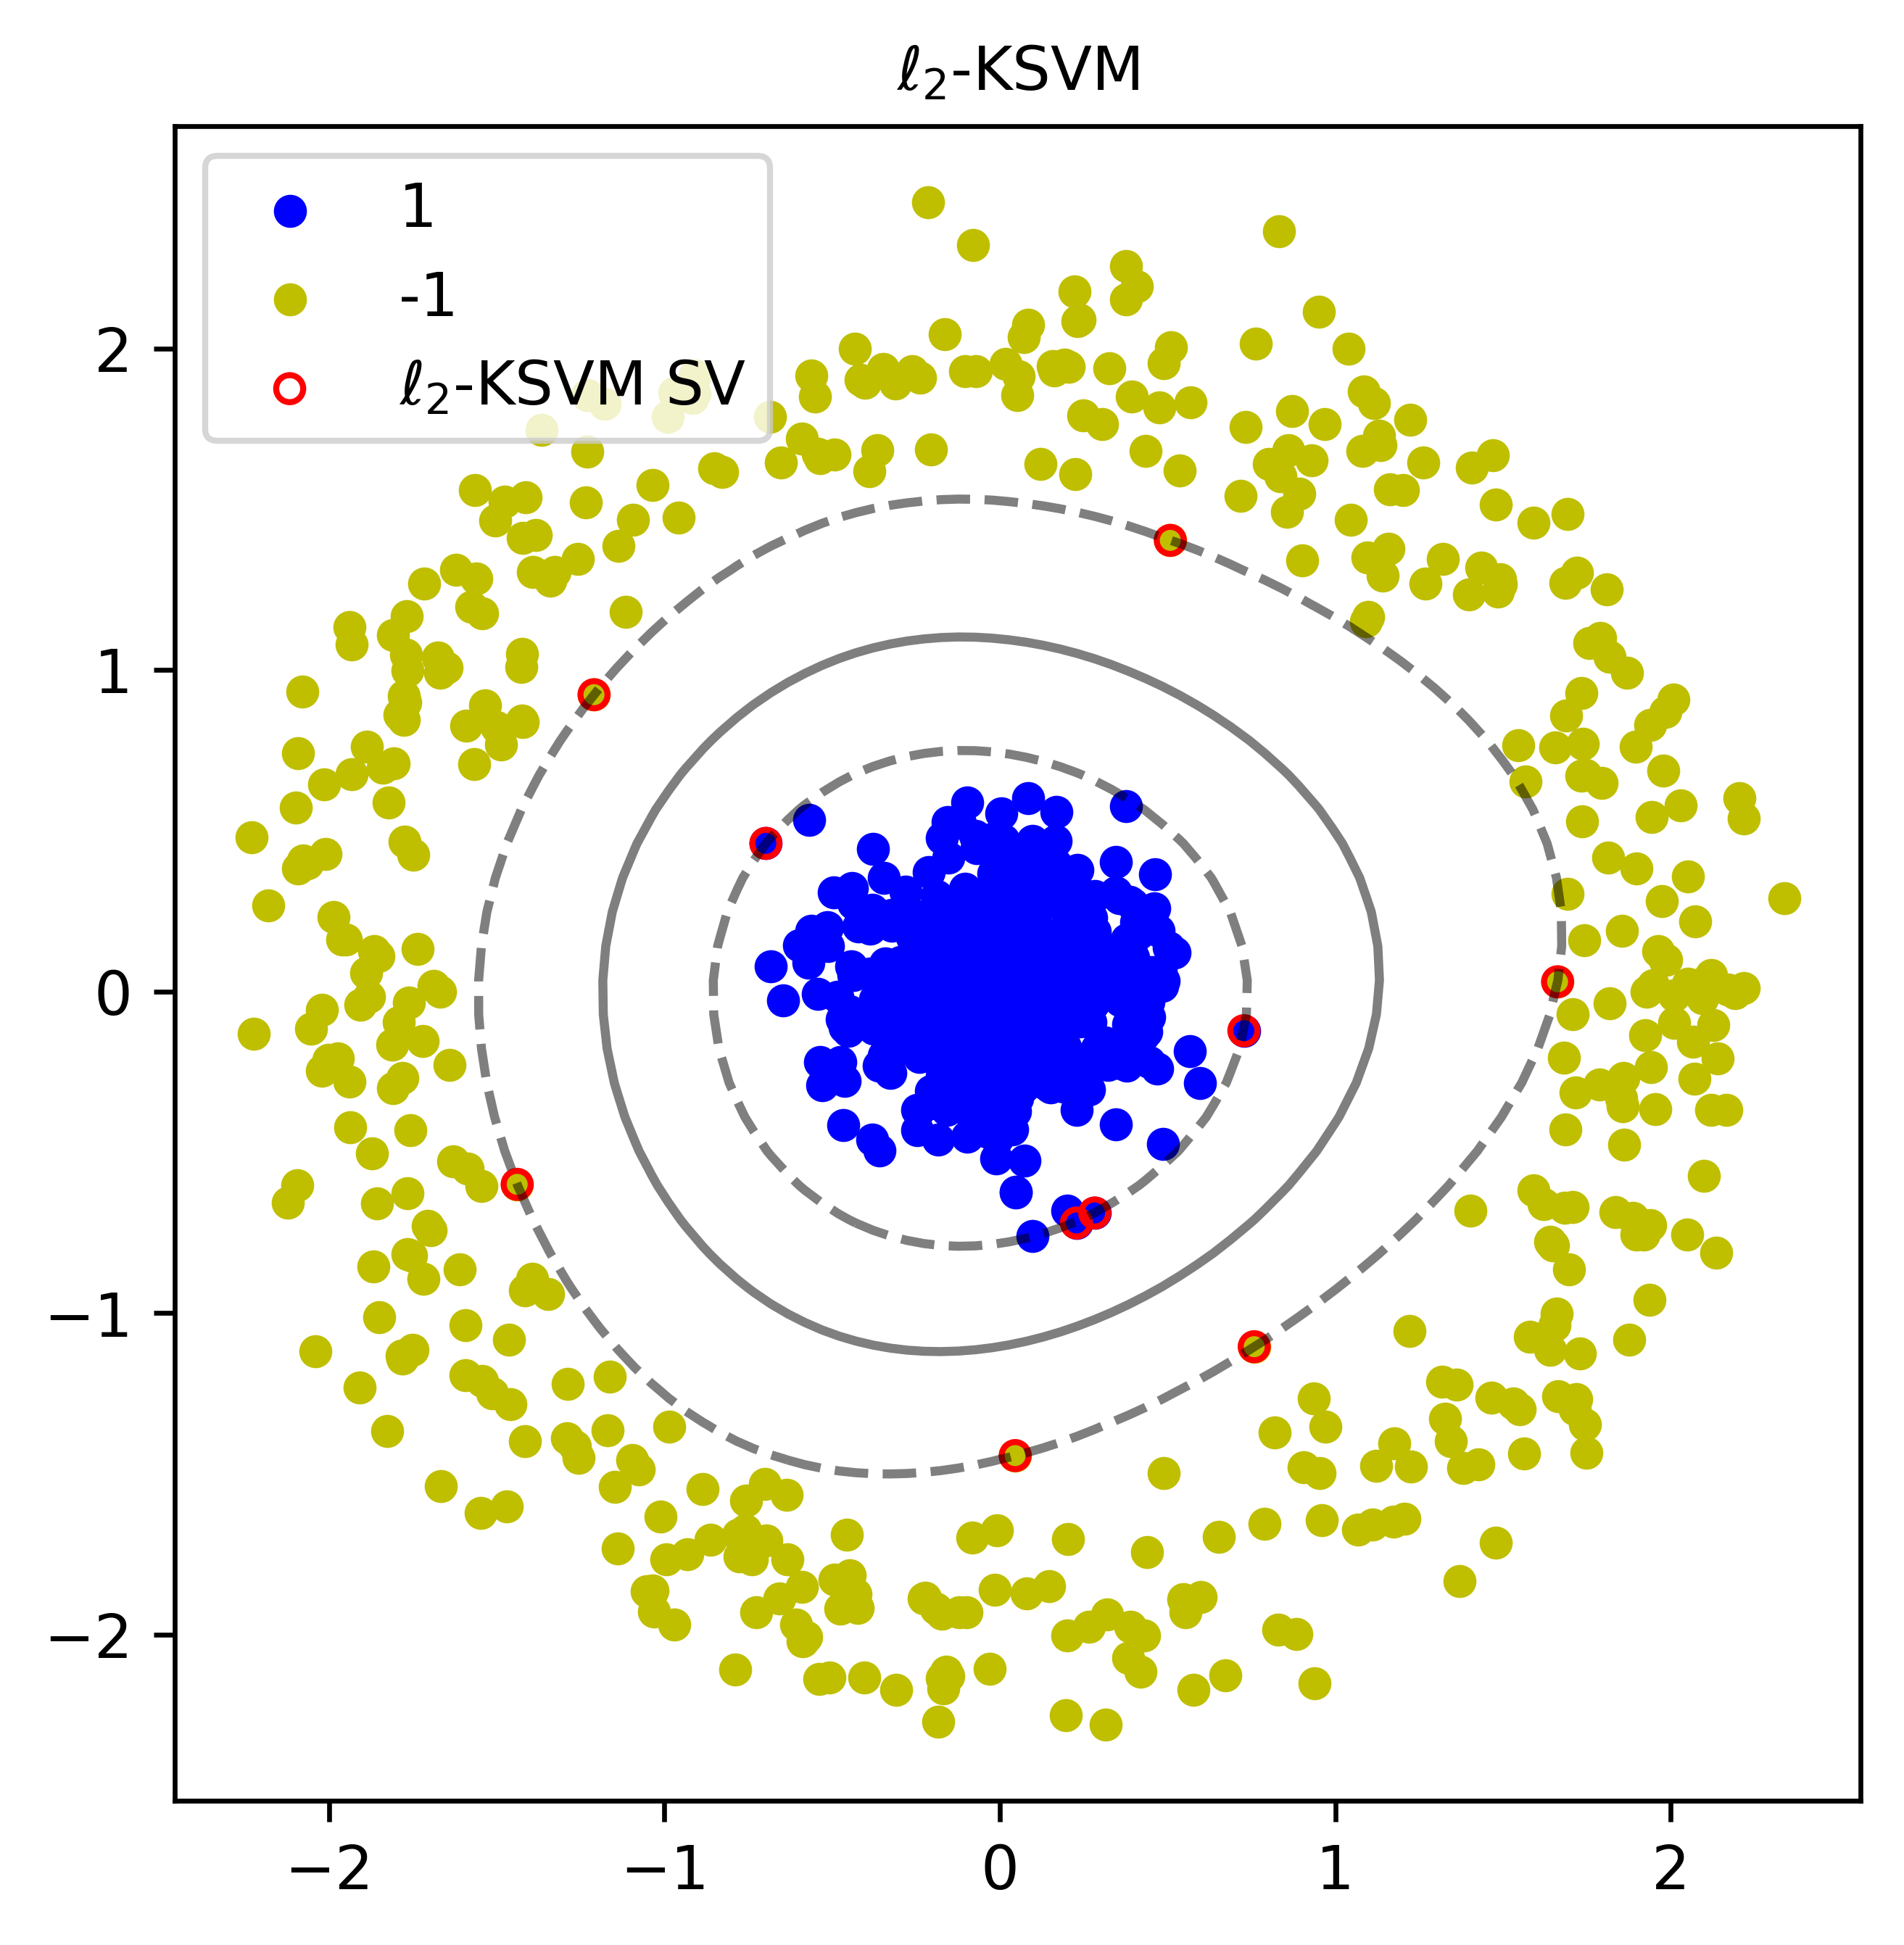

In [31]:
plt.rcParams['figure.figsize'] = (5, 5) 
plt.rcParams['figure.dpi'] = 600 #分辨率
plt.rcParams['font.size'] = '10'
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0],support_vectors[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_2$-KSVM SV')
plt.legend(loc = 'upper left')
plt.title(r'$\ell_2$-KSVM',fontsize=10)
plt.savefig('KSVM_DoubleCircle_L2KSVM.png', bbox_inches='tight')

# 4. $\ell_2$-KSVM by qbsolvers 

Number of traning data points= 900


D:\Software\anaconda\jupyter\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
D:\Software\anaconda\jupyter\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
D:\Software\anaconda\jupyter\Lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


(900,)


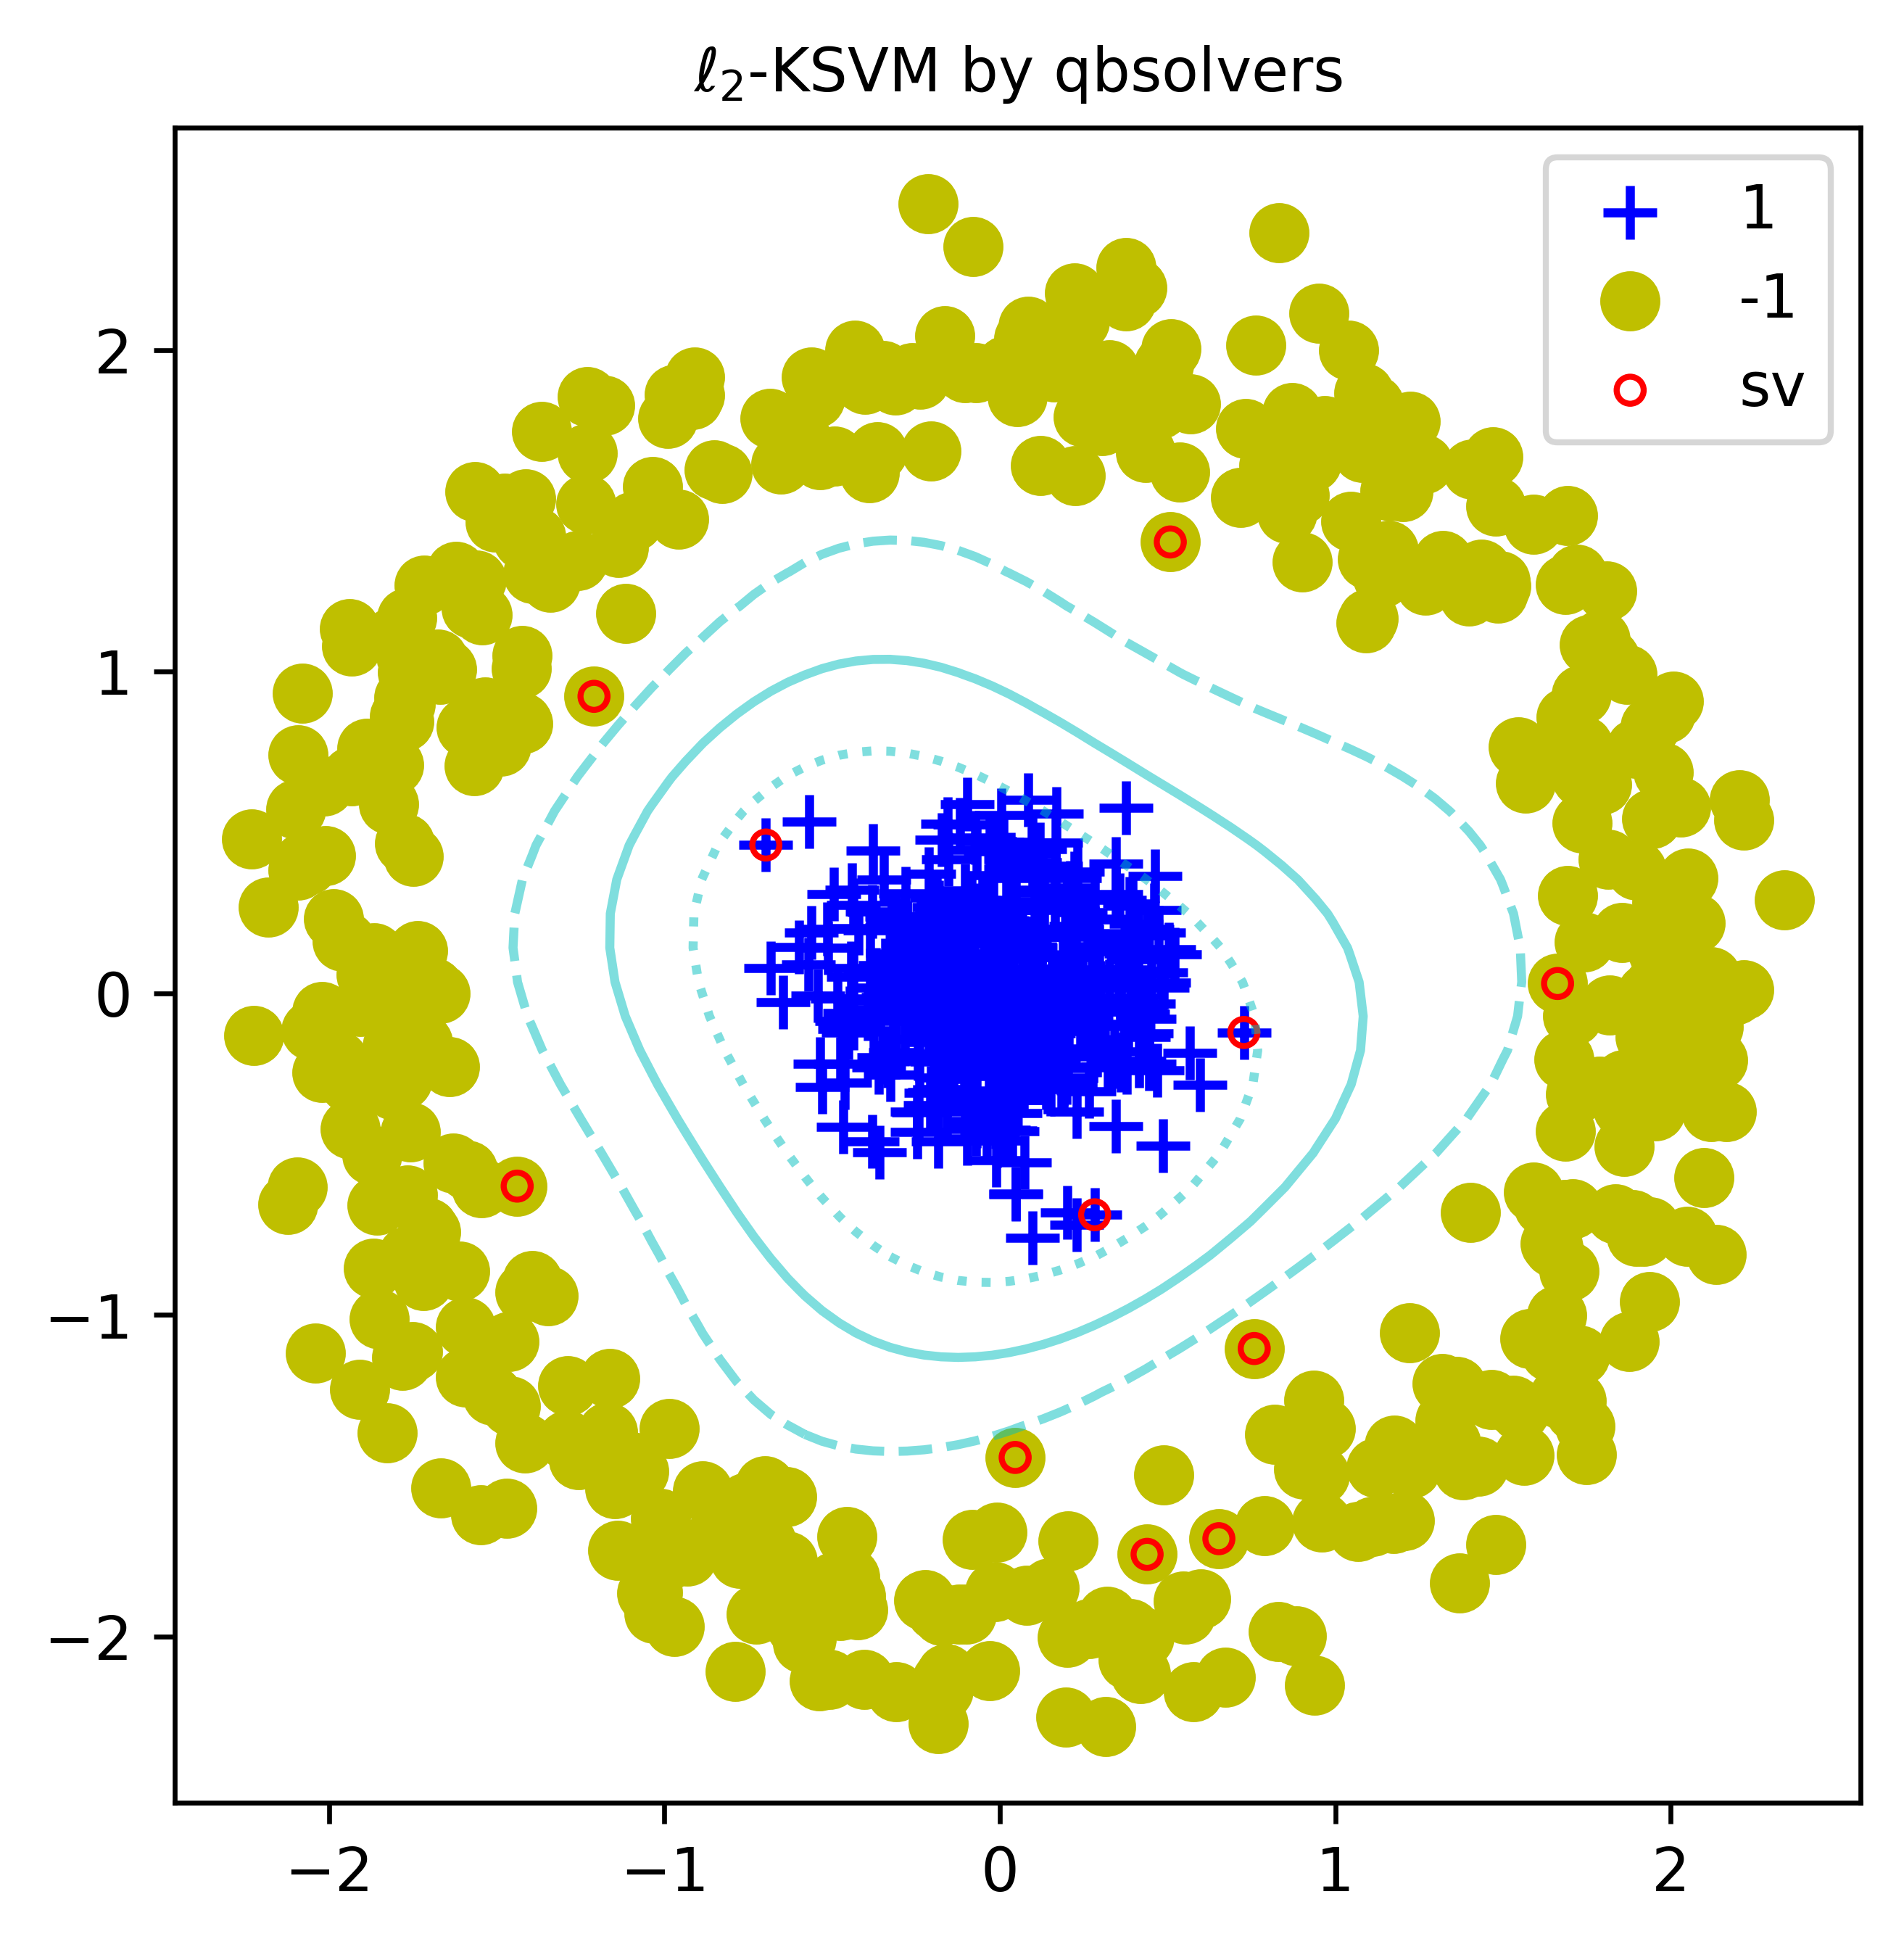

In [32]:
import numpy as np
import random
from qpsolvers import Problem, solve_problem
#pip install qpsolvers
#https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#qpsolvers.solve_qp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel


C=5  #参数可调
n=y_train.shape[0]
print('Number of traning data points=',n)

Y=np.diag(y_train)
K = rbf_kernel(X_train, Y=None) 
#linear'，'poly'，'polynomial'，'rbf'，'laplacian'
#print('Kernel Matrix =\n',K)
P=np.dot(np.dot(Y,K),Y)
#print('P =\n',P)
q = -1*np.ones(n)
A = np.array([y_train])
b = np.array([0])
G = np.vstack([-np.eye(n), np.eye(n)])  # 0<=x<=C
h = np.hstack([np.zeros(n),C* np.ones(n)])

problem = Problem(P, q, G, h, A, b)
solution = solve_problem(problem, solver='osqp') 
#qpsolvers.available_solvers = ['cvxopt', 'daqp', 'ecos', 'gurobi', 'highs', 'mosek', 'osqp', 
#'proxqp', 'qpoases', 'qpswift', 'quadprog', 'scs', 'nppro']

#print('Solution vector for the primal quadratic program=\n',solution.x)

plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.figsize'] = (5, 5) 
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = '+', color = 'b', label='1', s = 80)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 80)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = rbf_kernel(np.c_[xx.ravel(), yy.ravel()],X_train,gamma=1)


alpha=solution.x
print(alpha.shape)
sv=np.where(np.logical_and(alpha > 1e-3,alpha<C))
b=np.mean(y[sv] -np.dot(K[sv],np.multiply(alpha,y_train)))
#b=np.mean(y -np.dot(K,np.multiply(alpha,y)))
#print('b =',b)
#print('predict',np.dot(K,np.multiply(alpha,y) ) + b)
Y_classifiervalue=np.dot(K_classifier,np.multiply(alpha,y_train) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='c',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', ':'])
sv_points = X_train[sv]  #support vectors
plt.scatter(sv_points[:, 0],sv_points[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='sv')
plt.legend(loc = 'upper right')
plt.title(r'$\ell_2$-KSVM by qbsolvers',fontsize=10)
plt.savefig('KSVM_DoubleCircle_L2KSVM_qbsolvers.png', bbox_inches='tight')
#title = 'C = ' + str(C) + ', total SV = ' + str(len(alpha[alpha > 10e-3]))

# 5. $\ell_0$-KSVM by ADMM

5.1 ADMM代码

In [33]:
#Proximal operator of the L0-norm Hinge loss
def Prox(eta,threshold):
    eta[np.where(np.logical_and(eta>0,eta<=threshold))] = 0 
    return eta

start = time.time()
K = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
y = y_train
m=np.shape(X_train)[0]

    
#Initialization
c = np.zeros(m)               #coefficients
b=0                           #b=1,-1 bias
u = np.random.random(m)       #loss
Lambda = np.random.random(m)  #Multipliers
max_iter=2000                  #Maximum iteration
beta=np.zeros(4)              #KKT error
tol=1e-3                      #KKT tolerance level 

#Best parameters obtained by Gridseach
C=8
sigma=1
iota=1      #learning_rate=iota*sigma

for i in range(max_iter): 
          
    #updating u
    u_k=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y 
    eta=u_k- Lambda/sigma # eta=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y #np.dot(np.dot(y_diag,K),c)=np.multiply(y,np.dot(K,c))    
    u = Prox(eta,C/sigma)   
            
    #updating c   
    xi = np.ones(m)-u- b*y-Lambda/sigma
    c = linalg.solve(K+np.eye(m)/sigma,np.multiply(y,xi))   #np.dot(y_diag,xi)=np.multiply(y,xi)
        
    #updating b
    r = np.ones(m)- u- np.multiply(y,np.dot(K,c))-Lambda/sigma
    b = np.dot(y.T,r)/m
    
    #updating Lambda 
    w = u + np.multiply(y,np.dot(K,c)) + b*y - np.ones(m) 
    index = np.where(u==0)[0]
    index_c= np.nonzero(u)[0]
    Lambda[index]=Lambda[index]+iota*sigma*w[index]      
    Lambda[index_c]=0
    
    
    #proximal stationary point stopping rule
    beta[0]=np.linalg.norm(c+np.multiply(y,Lambda),2)/(1+np.linalg.norm(c,2))#c related to lambda；
    beta[1]=(np.abs(np.dot(y.T,Lambda)))/m  
    beta[2]=np.linalg.norm(w,2)/np.sqrt(m)  
    beta[3]=np.linalg.norm(u_k-u,2)/(1+np.linalg.norm(u,2)) 
    #print('KKT error beta',beta.T)
    if  np.amax(beta)<tol: 
        print('KKT condition (tolerance level=1e-4) is satisfied with iteration i:=',i+1)
        break  
        
end = time.time()
Iter = i+1
print('Program time of L0-KSVM is:%ss'%(str(end-start)))

#L0-KSVM Accuracy 
print('Train Accuracy=', accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
K_test = pairwise_kernels(X_test,X_train, metric='rbf') 
print('Test Accuracy=', accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))

KKT condition (tolerance level=1e-4) is satisfied with iteration i:= 653
Program time of L0-KSVM is:18.029038667678833s
Train Accuracy:
 1.0
Test Accuracy:
 1.0


5.2 Illustration of numerical results

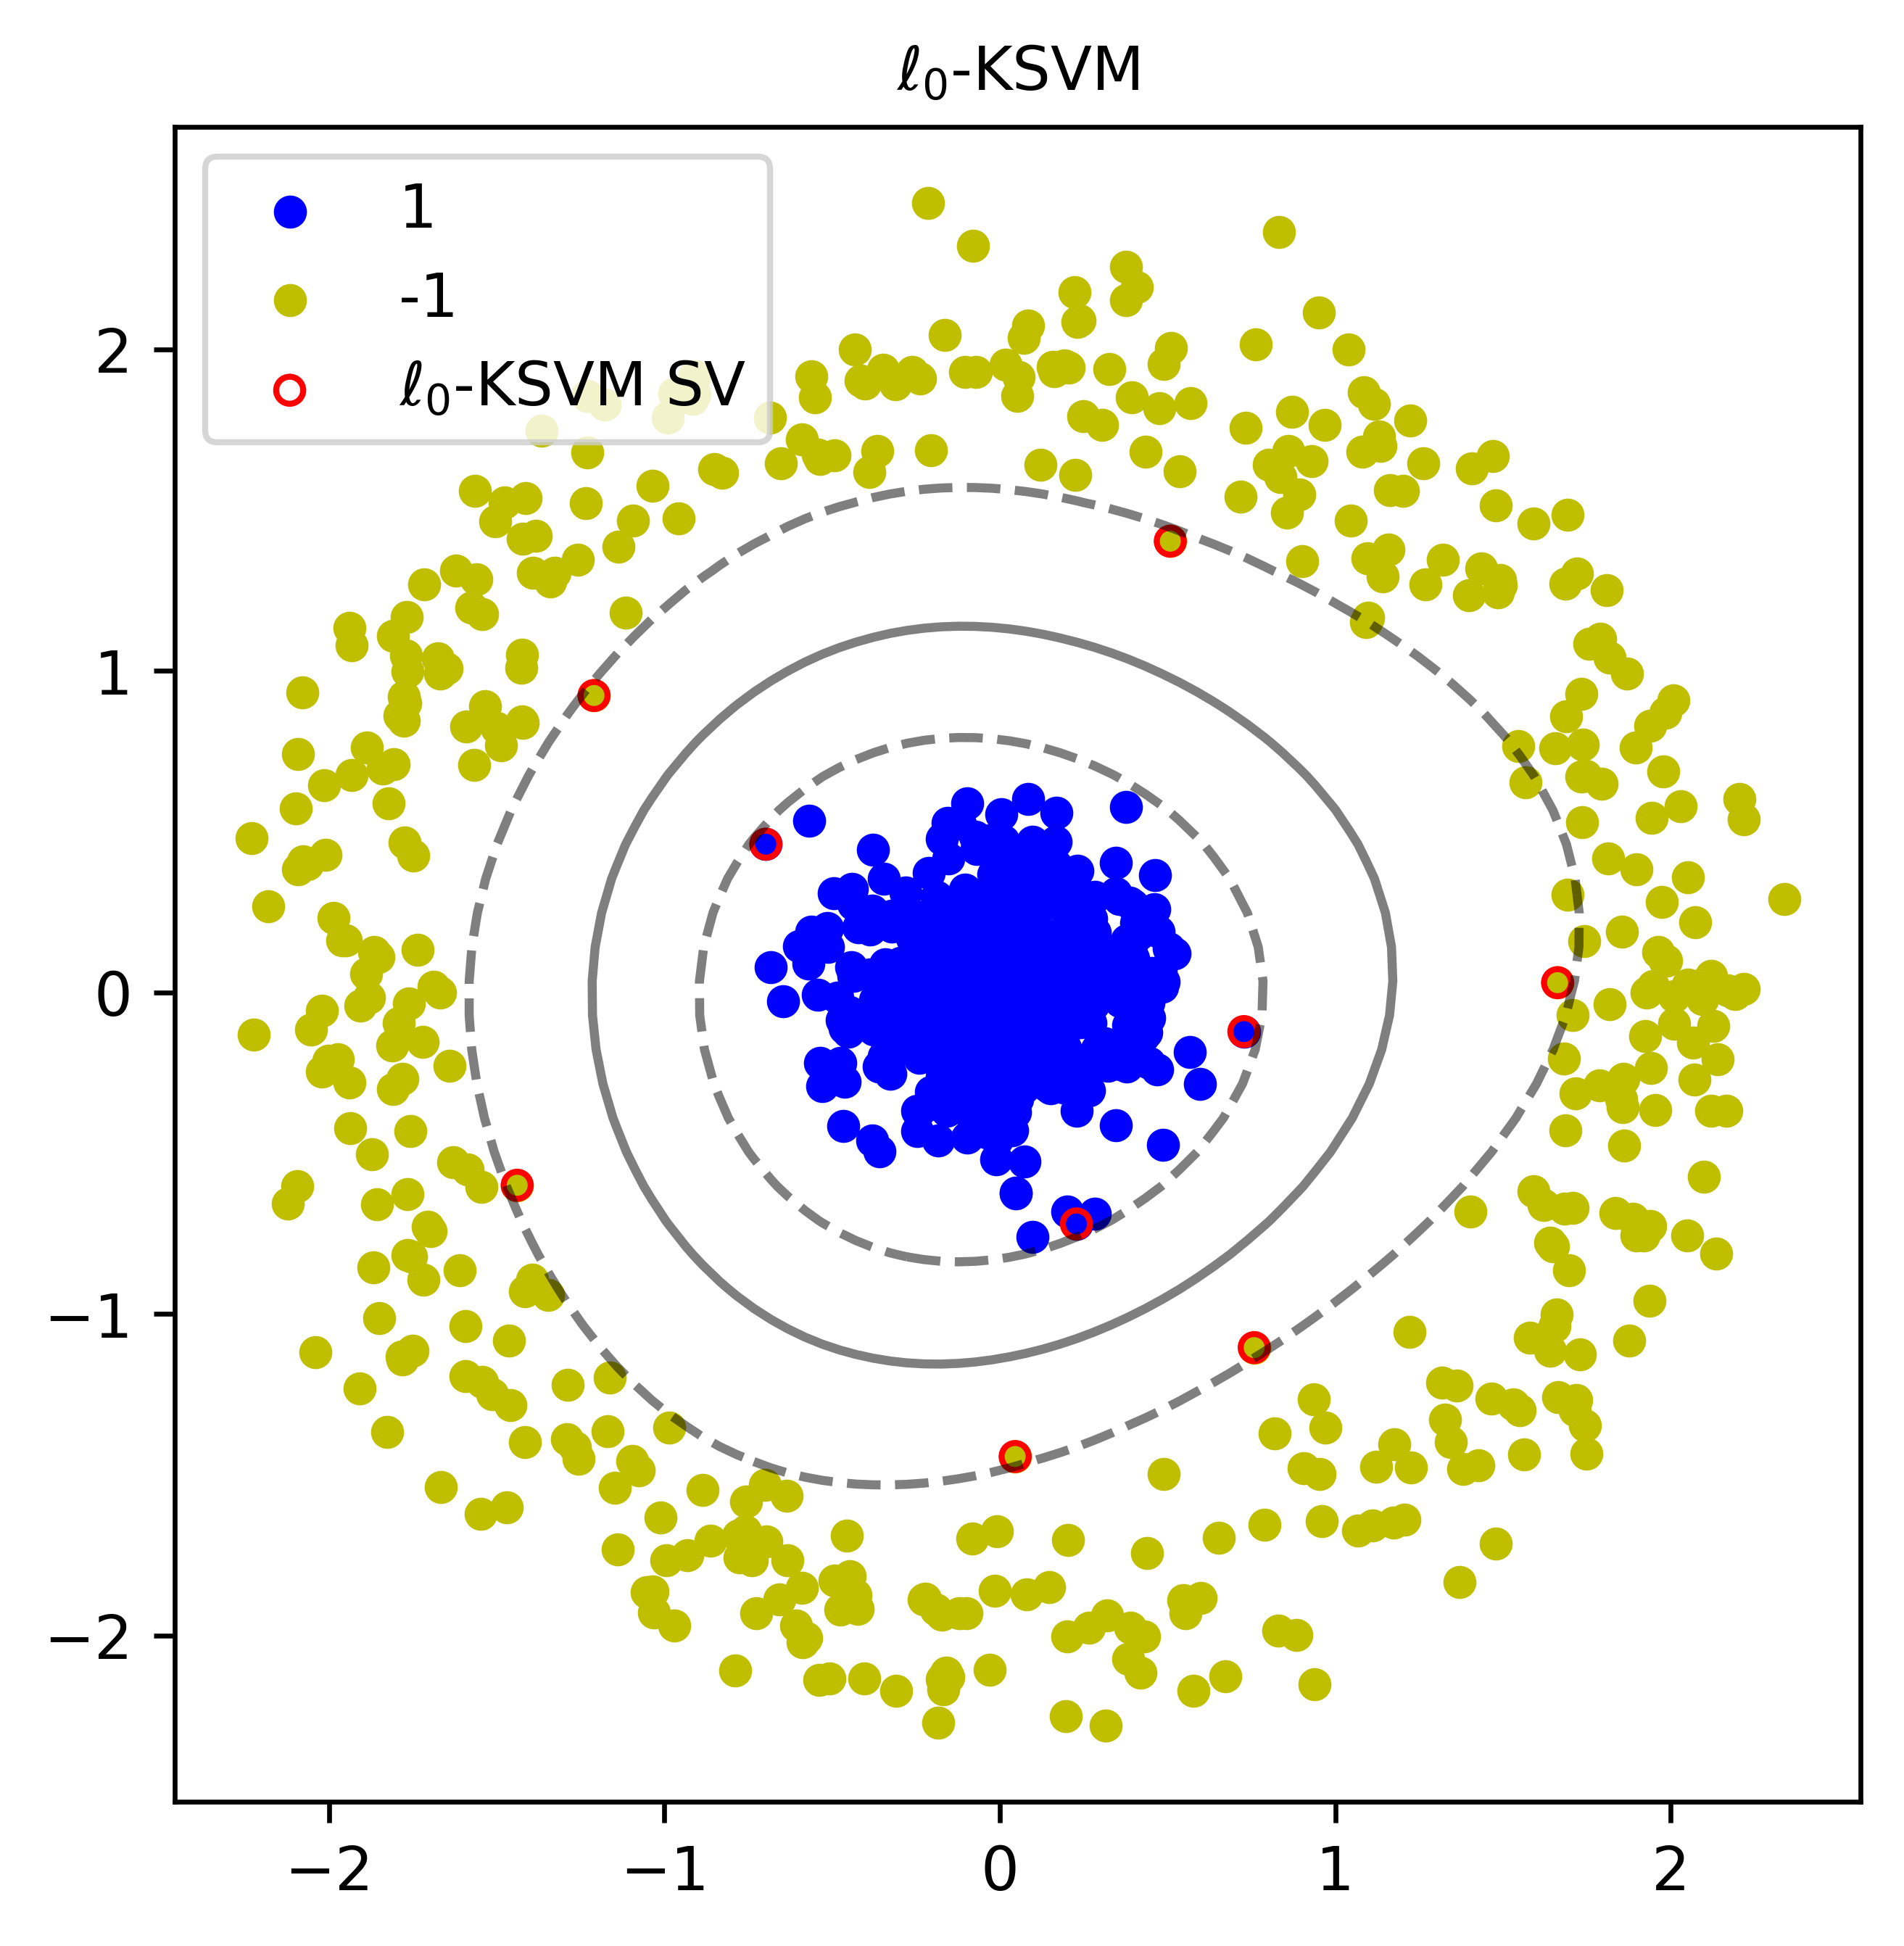

In [35]:
# ##L01KSVM:plot the decision function 
plt.rcParams['figure.figsize'] = (5, 5) 
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600

idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') 
Y_classifiervalue=-np.dot(K_classifier,np.multiply(Lambda,y) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv=np.nonzero(Lambda)[0] 
sv_L01Loss = X_train[index_sv]  #support vectors for L01KSVM
plt.scatter(sv_L01Loss[:, 0],sv_L01Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_0$-KSVM SV')
plt.legend(loc = 'upper left')
plt.title(r'$\ell_0$-KSVM',fontsize=10)
plt.savefig('KSVM_DoubleCircle_L0KSVM.png', bbox_inches='tight')

In [36]:
#Summary
#L01KSVM 
print({'C':C,'sigma':sigma,'iota':iota,'C1':C1,'C2':C2})
print('Threshold',np.sqrt((2*C)/sigma))

#dataset
print('Number of Training Data',m)
print('Number of Testing Data',y_test.shape[0])

#Accuracy
print('Train Accuracy of L0-KSVM:',accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
print('Test Accuracy of  L0-KSVM:',accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))
print('Train Accuracy of L1-KSVM:',accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
print('Test Accuracy of  L1-KSVM:',accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))
print('Train accuracy of L2-eKSVM:',clf.score(X_train,y_train))
print('Test accuracy of L2-eKSVM:',clf.score(X_test,y_test))

#Number of Support Vectors
print('Number of support vectors for L0-KSVM',len(index_sv))  
print('Number of support vectors for L1-KSVM',len(index_sv1))  
print('Number of support vectors for L2-KSVM:',np.sum(clf.n_support_))

#Computation Time
print('Computation Time for L01SVM',end-start)
print('Computation Time for L1SVM',end1-start1)
print('Computation Time for L2-KSVM',end2-start2)

{'C': 8, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
Threshold 4.0
Number of Training Data 900
Number of Testing Data 600
Train Accuracy of L0-KSVM: 1.0
Test Accuracy of  L0-KSVM: 1.0
Train Accuracy of L1-KSVM: 1.0
Test Accuracy of  L1-KSVM: 1.0
Train accuracy of L2-eKSVM: 1.0
Test accuracy of L2-eKSVM: 1.0
Number of support vectors for L0-KSVM 9
Number of support vectors for L1-KSVM 13
Number of support vectors for L2-KSVM: 10
Computation Time for L01SVM 18.029038667678833
Computation Time for L1SVM 0.3723325729370117
Computation Time for L2-KSVM 0.003989219665527344


# 6. 练习

 1. 支持向量机二分类问题评价指标：通过调整参数（如C,sigma,iota），核函数（'rbf'，‘linear’, ‘poly’, ‘laplacian’），得到最佳的训练和测试准确率

 2.替换Double Circles模拟数据集为Double Moons或真实数据集australian,diabetes, fourclass,  German, svmguide1等

 3. 竞赛排名评价（只针对任务的3. $\ell_2$-KSVM by sklearn）：分类的测试准确率